This is the final lab!

Link to our online report: https://typst.app/project/wh8vY0BQTzXHKzTLXigIDf

We can devide the task into:
1. Implement the Adaboost(DONE)
2. Generate the model selection procedure for Adaboost(Need to work on)
3. Document all the steps
4. Write the report

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import perceptron as pc
from sklearn.metrics import f1_score 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score




In [2]:
# Load the dataset
digits = load_digits()
X = digits.data
y = digits.target
# Print dataset details
print("Shape of data (features):", digits.data.shape)  # Feature matrix (n_samples, n_features)
print("Shape of images:", digits.images.shape)        # Images (n_samples, 8, 8)
print("Shape of target:", digits.target.shape)        # Labels (n_samples,)
print("Target classes:", np.unique(digits.target))    # Unique digit classes


Shape of data (features): (1797, 64)
Shape of images: (1797, 8, 8)
Shape of target: (1797,)
Target classes: [0 1 2 3 4 5 6 7 8 9]


In [3]:
from sklearn.model_selection import train_test_split


# Function to plot target value distributions
def plot_target_distribution(y, split_name):
    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color='skyblue', edgecolor='black')
    plt.xticks(unique)
    plt.title(f"Target Value Distribution in {split_name}")
    plt.xlabel("Digit Class")
    plt.ylabel("Count")
    plt.show()
    
def Accuracy(y_pred, y):
    '''
    OUTPUT :
    - accuracy: compare two outputs, calculate their accuracy
    '''
    val_accuracy = np.mean(y_pred == y)
    print(f"Testing Accuracy: {val_accuracy * 100:.2f}%")
    return val_accuracy

# Plot distributions for each split
#plot_target_distribution(y_train, "Training Set")
#plot_target_distribution(y_test, "Test Set")

In [4]:
# Split into train + test(The split of validation is in training session)

# Split 80% for training and 20% for validation + testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split 50% of the remaining 20% into validation and testing (10% each)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Store the binary labels for all classes
binary_y_train = {}
binary_y_valid = {}
binary_y_test = {}

# Iterate over each digit (0 to 9)
for k in range(10):
    # Create binary labels for class k in training set
    y_train_k = np.copy(y_train)
    y_train_k[y_train_k != k] = -1  # Set all other classes to -1
    y_train_k[y_train_k == k] = 1   # Set class k to 1
    binary_y_train[k] = y_train_k
    
    # Create binary labels for class k in training set
    y_valid_k = np.copy(y_valid)
    y_valid_k[y_valid_k != k] = -1  # Set all other classes to -1
    y_valid_k[y_valid_k == k] = 1   # Set class k to 1
    binary_y_valid[k] = y_valid_k

    # Create binary labels for class k in test set
    y_test_k = np.copy(y_test)
    y_test_k[y_test_k != k] = -1  # Set all other classes to -1
    y_test_k[y_test_k == k] = 1   # Set class k to 1
    binary_y_test[k] = y_test_k


# Now binary_y_train[k], binary_y_valid and binary_y_test[k] contain the binary labels for digit k
# This split will maintain until the whole SAMME is trained


'\n# Store the binary labels for all classes\nbinary_y_train = {}\nbinary_y_valid = {}\nbinary_y_test = {}\n\n# Iterate over each digit (0 to 9)\nfor k in range(10):\n    # Create binary labels for class k in training set\n    y_train_k = np.copy(y_train)\n    y_train_k[y_train_k != k] = -1  # Set all other classes to -1\n    y_train_k[y_train_k == k] = 1   # Set class k to 1\n    binary_y_train[k] = y_train_k\n    \n    # Create binary labels for class k in training set\n    y_valid_k = np.copy(y_valid)\n    y_valid_k[y_valid_k != k] = -1  # Set all other classes to -1\n    y_valid_k[y_valid_k == k] = 1   # Set class k to 1\n    binary_y_valid[k] = y_valid_k\n\n    # Create binary labels for class k in test set\n    y_test_k = np.copy(y_test)\n    y_test_k[y_test_k != k] = -1  # Set all other classes to -1\n    y_test_k[y_test_k == k] = 1   # Set class k to 1\n    binary_y_test[k] = y_test_k\n\n'

In [5]:
X_train.shape, X_valid.shape, X_test.shape

((1437, 64), (180, 64), (180, 64))

In [20]:
# Perceptron functions

def Perceptron_train(alpha, epoch, weight_samples, 
                     X_train_fold, y_train_fold, 
                     X_val_fold, y_val_fold):
    """
    Train Perceptron models for each class (0..9) with weighted samples, 
    but specifically on this fold's X_train_fold, y_train_fold.
    
    Returns:
      models: dict of {digit_k: trained Perceptron}
      error: float, combined weighted error
      y_Pred: array of shape (len(X_train_fold), ), multi-class predictions
      f1s: dict of per-digit F1 scores
    """
    accuracy = {}
    f1s = {}
    models = {}

    n_samples_fold = len(y_train_fold)

    # For storing final multi-class predictions on this fold's training set
    fill_value = -1
    y_Pred_fold = np.full(n_samples_fold, fill_value)

    # Iterate training over each digit (0 to 9)
    for k in range(10):
        print(f"Training Model for Class {k}")
        
        # Create binary labels for digit k in this fold
        # (Instead of referencing binary_y_train[k], do it inline)
        y_train_k = np.where(y_train_fold == k, 1, -1)
        y_val_k   = np.where(y_val_fold == k, 1, -1)

        # Initialize Perceptron model
        model_k = pc.Perceptron(alpha)
        
        # OLD: model_k.train(X_train, X_valid, binary_y_train[k], binary_y_valid[k], weight_samples, epochs=epoch)
        # NEW: pass the fold's data
        model_k.train(X_train_fold, X_val_fold, 
                      y_train_k, y_val_k, 
                      weight_samples, epochs=epoch)
        
        # We won't do "evaluate on X_test" here, because for cross-validation, there's no global test.
        # If you do want to see performance on the fold's val, do:
        y_val_pred_k = model_k.predict(X_val_fold)
        # maybe measure something if you want

        # Evaluate on the fold's training set to get misclassifications for the final error
        y_pred_k_train = model_k.predict(X_train_fold)

        # F1 score for this digit on training set
        prec_k, rec_k, f1_k = model_k.precision_recall_f1(y_pred_k_train, y_train_k)
        f1s[k] = f1_k

        # Combine predictions for multi-class on the training fold
        # If model k claims sample i => y_pred_k_train[i] == 1 => candidate digit
        for i in range(n_samples_fold):
            if y_pred_k_train[i] == 1:
                if y_Pred_fold[i] == -1:
                    y_Pred_fold[i] = k
                else:
                    # conflict => pick the digit with higher f1
                    current_class = y_Pred_fold[i]
                    if f1s[k] > f1s[current_class]:
                        y_Pred_fold[i] = k

        models[k] = model_k
    
    # Weighted error = sum of sample weights for misclassified samples
    misclassified = (y_Pred_fold != y_train_fold)
    error = np.sum(weight_samples[misclassified]) / np.sum(weight_samples)

    # If you want to see combined accuracy on the fold's training set:
    combined_acc = np.mean(y_Pred_fold == y_train_fold)
    combined_f1  = f1_score(y_train_fold, y_Pred_fold, average='macro')
    print(f"Combined train fold Accuracy: {combined_acc*100:.2f}%")
    print(f"Combined train fold F1: {combined_f1:.2f}")
    print(f"Combined Weighted Error: {error:.4f}\n")
    
    return models, error, y_Pred_fold, f1s

def Combined_predict(Models, X, Y, f1s):
    # Combine predictions for the multi-class task
    fill_value = -1  # Placeholder for unclassified samples
    y_Pred = np.full_like(Y, fill_value)  # Initialize predictions
    for k in range(10):
        y_pred_k = Models[k].predict(X)
        y_Pred[(y_pred_k == 1) & (y_Pred == fill_value)] = k  # Assign if unclassified
        # Update predictions for conflicts based on F1 scores
        conflict_indices = np.where((y_pred_k == 1) & (y_Pred != fill_value))[0]
        for idx in conflict_indices:
            current_class = y_Pred[idx]  # Existing predicted class
            if f1s[k] > f1s[current_class]:  # Compare F1 scores
                y_Pred[idx] = k  # Update to more reliable prediction
    return y_Pred




In [26]:
# SAMME & kfold Functions
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

def SAMME_predict_optimized(Weak_classifier_perceptrons, X_valid, y_valid, F1s, weight_Weak_classifier, n_classes=10, text = 'Final'):
    """
    Perform SAMME prediction by combining weighted votes from weak classifiers efficiently.

    """
    n_samples = X_valid.shape[0]
    votes = np.zeros((n_samples, n_classes))  # Accumulate votes for each class

    for t in range(len(Weak_classifier_perceptrons)):
        # Predict for all samples at once using the weak classifiers
        predictions_t = Combined_predict(Weak_classifier_perceptrons[t], X_valid, y_valid, F1s[t])
        valid_indices = predictions_t != -1  # Only count valid predictions

        # Update votes for valid predictions
        votes[valid_indices, predictions_t[valid_indices]] += weight_Weak_classifier[t]

    # Final prediction: the class with the most votes
    y_pred = np.argmax(votes, axis=1)

    # Evaluate final model
    accuracy = np.mean(y_pred == y_valid)
    f1 = f1_score(y_valid, y_pred, average='macro')
    print(text,f" SAMME Accuracy: {accuracy * 100:.2f}%")
    print(text,f" SAMME F1-score: {f1:.2f}")
    
    return y_pred, accuracy, f1

def run_samme(X_train_fold, y_train_fold, X_val_fold, y_val_fold,
              T=5, alpha=0.01, epoch=10):
    n_samples = len(y_train_fold) # this gives issues if n_samples !=  len(y_train_fold)
    weight_samples = np.ones(n_samples)/n_samples
    n_classes = 10
    
    Weak_classifier_perceptrons = {}
    weight_Weak_classifier = {}
    F1s = {}
    Errors = {}

    for t in range(T):
        Models_temp, Error, y_Pred_fold, f1s_dict = Perceptron_train(
            alpha, epoch, weight_samples,
            X_train_fold, y_train_fold, 
            X_val_fold, y_val_fold
        )
        Errors[t] = Error
        if Error >= 0.5:
            print("Classifier has high error, skipping.\n")
            continue
        
        F1s[t] = f1s_dict
        Weak_classifier_perceptrons[t] = Models_temp
        alpha_t = np.log((1 - Error)/Error) + np.log(n_classes -1)
        weight_Weak_classifier[t] = alpha_t
        
        # Update sample weights
        for i in range(n_samples):
            if y_Pred_fold[i] != y_train_fold[i]:
                weight_samples[i] *= np.exp(alpha_t)
        weight_samples /= np.sum(weight_samples)
    

    return Weak_classifier_perceptrons, F1s, weight_Weak_classifier, Errors


def cross_val_samme(X, y, T, alpha, epoch, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_f1s = []
    acc_vals = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Train model
        Weak_classifier_perceptrons,F1s,weight_Weak_classifier, Errors = run_samme(
            X_train_fold, y_train_fold,
            X_val_fold, y_val_fold,
            T=T, alpha=alpha, epoch=epoch
        )

        # Evaluate
        y_val_pred, acc_val, f1_val = SAMME_predict_optimized(
            Weak_classifier_perceptrons,
            X_val_fold,
            y_val_fold,
            F1s,
            weight_Weak_classifier
        )
        
        fold_f1s.append(f1_val)
        acc_vals.append(acc_val)
        
        print(f"Fold {fold_idx}: F1={f1_val:.2f}, Accuracy={acc_val:.2f}")

    avg_f1 = np.mean(fold_f1s)
    avg_acc = np.mean(acc_vals)
    print(f"Average F1 across {n_splits} folds: {avg_f1:.2f}")
    print(f"Average accuracy across {n_splits} folds: {avg_acc:.2f}")
    
    # Return both the per-fold lists and the averages
    return fold_f1s, acc_vals, avg_f1, avg_acc


In [8]:
'''T_candidates = [3, 5, 10]
alpha_candidates = [0.001, 0.005]
epoch_candidates = [80,100]


best_score = -1.0
best_params = None
params = {}

f1_cvs = []
acc_cvs = []
i = 1
for T_ in T_candidates:
    for alpha_ in alpha_candidates:
        for epoch_ in epoch_candidates:
            fold_f1s, acc_vals, f1_cv,acc_cv = cross_val_samme(X, y, T_, alpha_, epoch_, n_splits=5)
            f1_cvs.append(f1_cv)
            acc_cvs.append(acc_cv)
            params[i] = (T_, alpha_, epoch_, f1_cv, acc_cv)
            i+=1
            if f1_cv > best_score:
                best_score = f1_cv
                best_params = (T_, alpha_, epoch_)

print("Best params from CV:", best_params, "score:", best_score)'''


'T_candidates = [3, 5, 10]\nalpha_candidates = [0.001, 0.005]\nepoch_candidates = [80,100]\n\n\nbest_score = -1.0\nbest_params = None\nparams = {}\n\nf1_cvs = []\nacc_cvs = []\ni = 1\nfor T_ in T_candidates:\n    for alpha_ in alpha_candidates:\n        for epoch_ in epoch_candidates:\n            fold_f1s, acc_vals, f1_cv,acc_cv = cross_val_samme(X, y, T_, alpha_, epoch_, n_splits=5)\n            f1_cvs.append(f1_cv)\n            acc_cvs.append(acc_cv)\n            params[i] = (T_, alpha_, epoch_, f1_cv, acc_cv)\n            i+=1\n            if f1_cv > best_score:\n                best_score = f1_cv\n                best_params = (T_, alpha_, epoch_)\n\nprint("Best params from CV:", best_params, "score:", best_score)'

In [9]:
'''params'''

'params'

In [10]:
# We choose (10, 0.1, 100) as the best parameter
best_params = (10, 0.1, 100)


In [11]:
best_T, best_alpha, best_epoch = best_params
print({ best_T,best_alpha, best_epoch})
'''
folds = np.arange(len(fold_f1s))
# Bar Chart of Per-Fold F1 Scores
plt.bar(folds, fold_f1s, color='skyblue', edgecolor='black')
plt.xticks(folds, [f"Fold {i}" for i in folds])
plt.ylabel("F1 Score")
plt.title("K-Fold F1 Scores for SAMME")
plt.ylim([0, 1])  # If you expect F1 in [0..1]
plt.show()

# Line Chart of Accuracy vs. Fold
plt.plot(folds, acc_vals, marker='o', color='blue')
plt.xticks(folds, [f"Fold {i}" for i in folds])
plt.ylabel("Accuracy")
plt.title("K-Fold Accuracy for SAMME")
plt.ylim([0, 1])
plt.show()'''

{0.1, 10, 100}


'\nfolds = np.arange(len(fold_f1s))\n# Bar Chart of Per-Fold F1 Scores\nplt.bar(folds, fold_f1s, color=\'skyblue\', edgecolor=\'black\')\nplt.xticks(folds, [f"Fold {i}" for i in folds])\nplt.ylabel("F1 Score")\nplt.title("K-Fold F1 Scores for SAMME")\nplt.ylim([0, 1])  # If you expect F1 in [0..1]\nplt.show()\n\n# Line Chart of Accuracy vs. Fold\nplt.plot(folds, acc_vals, marker=\'o\', color=\'blue\')\nplt.xticks(folds, [f"Fold {i}" for i in folds])\nplt.ylabel("Accuracy")\nplt.title("K-Fold Accuracy for SAMME")\nplt.ylim([0, 1])\nplt.show()'

In [22]:
Weak_classifier_perceptrons,F1s,weight_Weak_classifier,Errors = run_samme(
            X_train, y_train,
            X_valid, y_valid,
            T=best_T, alpha=best_alpha, epoch=best_epoch
        )


Training Model for Class 0
Validation Accuracy: 100.00%
Validation precision: 100.00%
Validation recall: 100.00%
Validation f1_score: 1.00
Training Model for Class 1
Validation Accuracy: 98.89%
Validation precision: 93.33%
Validation recall: 93.33%
Validation f1_score: 0.93
Training Model for Class 2
Validation Accuracy: 98.89%
Validation precision: 93.75%
Validation recall: 93.75%
Validation f1_score: 0.94
Training Model for Class 3
Validation Accuracy: 98.33%
Validation precision: 94.12%
Validation recall: 88.89%
Validation f1_score: 0.91
Training Model for Class 4
Validation Accuracy: 99.44%
Validation precision: 100.00%
Validation recall: 95.65%
Validation f1_score: 0.98
Training Model for Class 5
Validation Accuracy: 99.44%
Validation precision: 96.43%
Validation recall: 100.00%
Validation f1_score: 0.98
Training Model for Class 6
Validation Accuracy: 99.44%
Validation precision: 100.00%
Validation recall: 95.65%
Validation f1_score: 0.98
Training Model for Class 7
Validation Accu

NameError: name 'plot_training_progress' is not defined

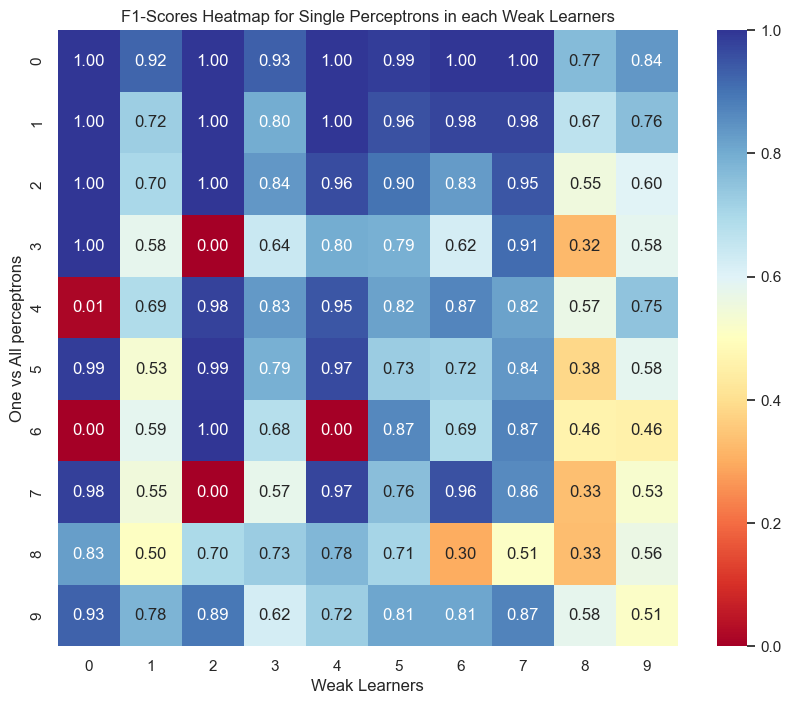

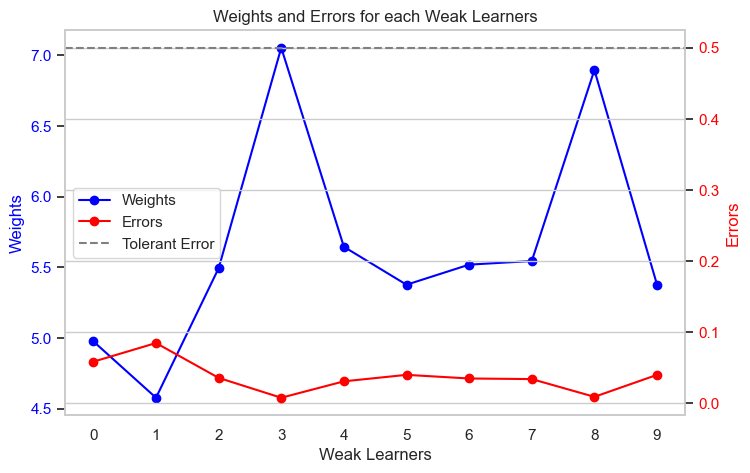

In [50]:
import seaborn as sns

# Prepare data for F1 heatmap
iterations = list(F1s.keys())
classes = list(F1s[0].keys())
f1_matrix = np.array([[F1s[iter_][cls] for cls in classes] for iter_ in iterations])
# Plot F1 heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(f1_matrix, annot=True, cmap="RdYlBu", fmt=".2f", xticklabels=classes, yticklabels=iterations)
plt.title("F1-Scores Heatmap for Single Perceptrons in each Weak Learners")
plt.xlabel("Weak Learners")
plt.ylabel("One vs All perceptrons")
plt.show()

# Plotting weights and errors on the same plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot weights on primary y-axis
ax1.plot(weight_Weak_classifier.keys(), weight_Weak_classifier.values(), marker="o", label="Weights", color="blue")
ax1.set_xlabel("Weak Learners")
ax1.set_ylabel("Weights", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Update x-axis ticks
ax1.set_xticks(list(weight_Weak_classifier.keys()))

# Plot errors on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(Errors.keys(), Errors.values(), marker="o", label="Errors", color="red")
ax2.axhline(y=0.5, color="gray", linestyle="--", label="Tolerant Error")
ax2.set_ylabel("Errors", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Title and grid
plt.title("Weights and Errors for each Weak Learners")
ax1.grid()
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center left")

plt.show()

In [13]:
#validate error
y_val_pred, acc_val, f1_val = SAMME_predict_optimized(
        Weak_classifier_perceptrons,
        X_valid,
        y_valid,
        F1s,
        weight_Weak_classifier,
        text = "Validate"
    )
# testing error
y_pred, acc_val, f1_val = SAMME_predict_optimized(
        Weak_classifier_perceptrons,
        X_test,
        y_test,
        F1s,
        weight_Weak_classifier,
        text = "Test"
    )

Validate  SAMME Accuracy: 96.11%
Validate  SAMME F1-score: 0.96
Test  SAMME Accuracy: 97.22%
Test  SAMME F1-score: 0.97


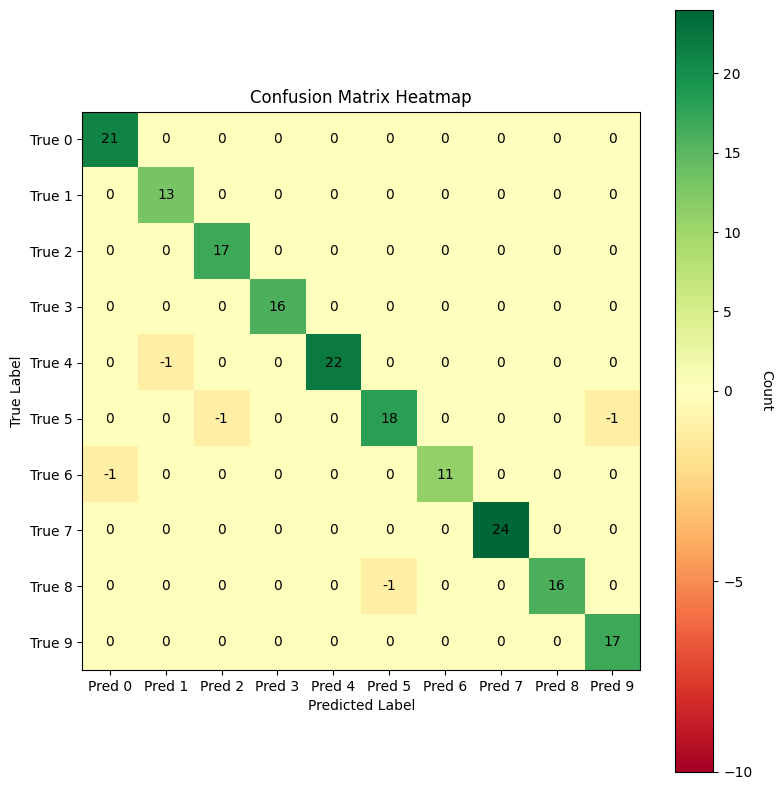

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Recreating the confusion matrix for visualization (adjust as needed for real data)
confusion_matrix = np.zeros((10, 10))
for t, p in zip(y_test, y_pred):
    if t==p:
        confusion_matrix[t, p] += 1
    if t!=p:
        confusion_matrix[t, p] -= 1

# Setting up the color map with white at 0, red for negatives, green for positives
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=confusion_matrix.max())
cmap = plt.cm.RdYlGn

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(confusion_matrix, cmap=cmap, norm=norm)

# Adding color bar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Count", rotation=270, labelpad=15)

# Labeling the axes
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels([f"Pred {i}" for i in range(10)])
ax.set_yticklabels([f"True {i}" for i in range(10)])

# Adding annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, int(confusion_matrix[i, j]),
                       ha="center", va="center",
                       color="black")

# Adding gridlines for better visualization
ax.set_title("Confusion Matrix Heatmap")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.tight_layout()
plt.show()


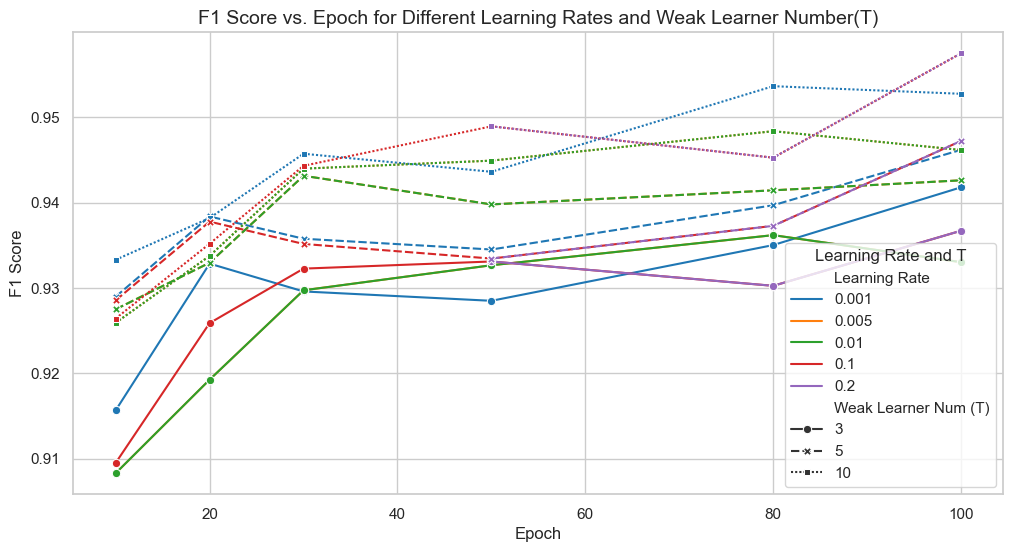

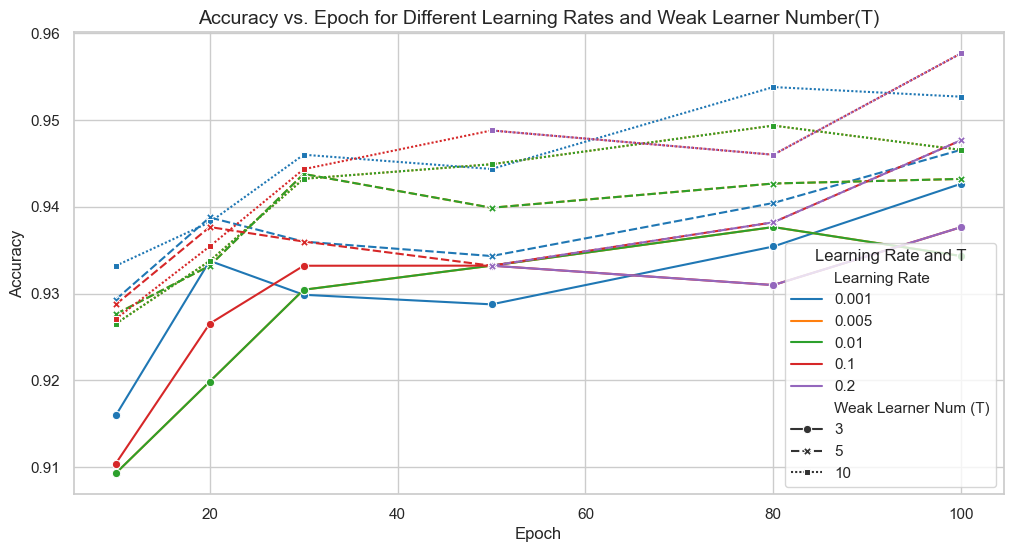

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the two dictionaries into one
data1 = {1: (3, 0.001, 10, 0.9156633641654626, 0.9159656453110492),
 2: (3, 0.001, 20, 0.9328572228361048, 0.9337790157845868),
 3: (3, 0.001, 30, 0.9295986708860609, 0.9298700092850511),
 4: (3, 0.001, 50, 0.9285012356020953, 0.9287650882079852),
 5: (3, 0.005, 10, 0.908296851146634, 0.9093036211699165),
 6: (3, 0.005, 20, 0.9192602539257013, 0.9198653667595172),
 7: (3, 0.005, 30, 0.9297337170433121, 0.9304472299597648),
 8: (3, 0.005, 50, 0.9326675324657702, 0.9332250077375426),
 9: (3, 0.01, 10, 0.908296851146634, 0.9093036211699165),
 10: (3, 0.01, 20, 0.9192602539257013, 0.9198653667595172),
 11: (3, 0.01, 30, 0.9297337170433121, 0.9304472299597648),
 12: (3, 0.01, 50, 0.9326675324657702, 0.9332250077375426),
 13: (3, 0.1, 10, 0.9095017919654541, 0.9104178272980501),
 14: (3, 0.1, 20, 0.9258887717384221, 0.9265444134942742),
 15: (3, 0.1, 30, 0.9322715718002227, 0.9332141751779636),
 16: (3, 0.1, 50, 0.9331090633327094, 0.9332234602290314),
 17: (5, 0.001, 10, 0.9289845222144578, 0.9293190962550293),
 18: (5, 0.001, 20, 0.9383830869072346, 0.9387821108016094),
 19: (5, 0.001, 30, 0.9357730022056494, 0.9359950479727639),
 20: (5, 0.001, 50, 0.934512689031082, 0.9343330238316311),
 21: (5, 0.005, 10, 0.9275055816386345, 0.9276415970287836),
 22: (5, 0.005, 20, 0.932959541538921, 0.9332141751779635),
 23: (5, 0.005, 30, 0.9431513486861371, 0.9437898483441659),
 24: (5, 0.005, 50, 0.9397943014974427, 0.9398978644382543),
 25: (5, 0.01, 10, 0.9275055816386345, 0.9276415970287836),
 26: (5, 0.01, 20, 0.932959541538921, 0.9332141751779635),
 27: (5, 0.01, 30, 0.9431513486861371, 0.9437898483441659),
 28: (5, 0.01, 50, 0.9397943014974427, 0.9398978644382543),
 29: (5, 0.1, 10, 0.9285519583105721, 0.9287542556484061),
 30: (5, 0.1, 20, 0.9377794692766832, 0.9376756422160323),
 31: (5, 0.1, 30, 0.9351635311279957, 0.9360027855153203),
 32: (5, 0.1, 50, 0.9334491270334933, 0.9332157226864748),
 33: (10, 0.001, 10, 0.933307969693827, 0.9332079851439182),
 34: (10, 0.001, 20, 0.9381968303569608, 0.9382281027545651),
 35: (10, 0.001, 30, 0.9457328098282423, 0.9460074280408541),
 36: (10, 0.001, 50, 0.9436181801031026, 0.9443624264933457),
 37: (10, 0.005, 10, 0.9259224580772714, 0.9265304859176725),
 38: (10, 0.005, 20, 0.9337585217035389, 0.9337604456824511),
 39: (10, 0.005, 30, 0.9439845007737521, 0.9432342927886104),
 40: (10, 0.005, 50, 0.944923597604807, 0.9449086969978335),
 41: (10, 0.01, 10, 0.9259224580772714, 0.9265304859176725),
 42: (10, 0.01, 20, 0.9337585217035389, 0.9337604456824511),
 43: (10, 0.01, 30, 0.9439845007737521, 0.9432342927886104),
 44: (10, 0.01, 50, 0.944923597604807, 0.9449086969978335),
 45: (10, 0.1, 10, 0.9264245865866867, 0.9270875889817394),
 46: (10, 0.1, 20, 0.9351861475905515, 0.9354441349427421),
 47: (10, 0.1, 30, 0.9443197386318228, 0.9443407613741875),
 48: (10, 0.1, 50, 0.9489421346928533, 0.9488006809037449)}

data2 = {1: (3, 0.01, 50, 0.9326675324657702, 0.9332250077375426),
 2: (3, 0.01, 80, 0.9361948309950143, 0.9376725471990095),
 3: (3, 0.01, 100, 0.9330270193647501, 0.9343299288146085),
 4: (3, 0.1, 50, 0.9331090633327094, 0.9332234602290314),
 5: (3, 0.1, 80, 0.9302552124242485, 0.9309873104302074),
 6: (3, 0.1, 100, 0.9367126844696267, 0.9376648096564532),
 7: (3, 0.2, 50, 0.9331090633327094, 0.9332234602290314),
 8: (3, 0.2, 80, 0.9302552124242485, 0.9309873104302074),
 9: (3, 0.2, 100, 0.9367126844696267, 0.9376648096564532),
 10: (5, 0.01, 50, 0.9397943014974427, 0.9398978644382543),
 11: (5, 0.01, 80, 0.9414468702812833, 0.9426895697926339),
 12: (5, 0.01, 100, 0.9426182698342551, 0.9432188177034974),
 13: (5, 0.1, 50, 0.9334491270334933, 0.9332157226864748),
 14: (5, 0.1, 80, 0.937281281642864, 0.938217270194986),
 15: (5, 0.1, 100, 0.9472373139598084, 0.9476818322500774),
 16: (5, 0.2, 50, 0.9334491270334933, 0.9332157226864748),
 17: (5, 0.2, 80, 0.937281281642864, 0.938217270194986),
 18: (5, 0.2, 100, 0.9472373139598084, 0.9476818322500774),
 19: (10, 0.01, 50, 0.944923597604807, 0.9449086969978335),
 20: (10, 0.01, 80, 0.9483729099622178, 0.9493655215103682),
 21: (10, 0.01, 100, 0.9461699952532936, 0.9465598885793872),
 22: (10, 0.1, 50, 0.9489421346928533, 0.9488006809037449),
 23: (10, 0.1, 80, 0.9452699364512223, 0.9460058805323429),
 24: (10, 0.1, 100, 0.9575057796383563, 0.9576988548437017),
 25: (10, 0.2, 50, 0.9489421346928533, 0.9488006809037449),
 26: (10, 0.2, 80, 0.9452699364512223, 0.9460058805323429),
 27: (10, 0.2, 100, 0.9575057796383563, 0.9576988548437017),
 }
data3 = {1: (3, 0.001, 80, 0.9350300144960155, 0.9354317548746518),
 2: (3, 0.001, 100, 0.941800469770763, 0.9426679046734756),
 3: (3, 0.005, 80, 0.9361948309950143, 0.9376725471990095),
 4: (3, 0.005, 100, 0.9330270193647501, 0.9343299288146085),
 5: (5, 0.001, 80, 0.9396962381832207, 0.9404456824512535),
 6: (5, 0.001, 100, 0.9461930587808123, 0.9465769111730115),
 7: (5, 0.005, 80, 0.9414468702812833, 0.9426895697926339),
 8: (5, 0.005, 100, 0.9426182698342551, 0.9432188177034974),
 9: (10, 0.001, 80, 0.9536476621857248, 0.9538037759207676),
 10: (10, 0.001, 100, 0.9527549287143552, 0.9526926648096564),
 11: (10, 0.005, 80, 0.9483729099622178, 0.9493655215103682),
 12: (10, 0.005, 100, 0.9461699952532936, 0.9465598885793872)}
# Convert to DataFrame
data1_df = pd.DataFrame.from_dict(data1, orient="index", columns=["Weak Learner Num (T)", "Learning Rate", "Epoch", "F1 Score", "Accuracy"])
data2_df = pd.DataFrame.from_dict(data2, orient="index", columns=["Weak Learner Num (T)", "Learning Rate", "Epoch", "F1 Score", "Accuracy"])
data3_df = pd.DataFrame.from_dict(data3, orient="index", columns=["Weak Learner Num (T)", "Learning Rate", "Epoch", "F1 Score", "Accuracy"])
data_df = pd.concat([data1_df, data2_df, data3_df], ignore_index=True)

# Visualization
sns.set(style="whitegrid")

# Plot F1 Score vs Epoch for different learning rates
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data_df,
    x="Epoch",
    y="F1 Score",
    hue="Learning Rate",
    style="Weak Learner Num (T)",
    markers=True,
    palette="tab10"
)
plt.title("F1 Score vs. Epoch for Different Learning Rates and Weak Learner Number(T)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.legend(title="Learning Rate and T")
plt.show()

# Plot Accuracy vs Epoch for different learning rates
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=data_df,
    x="Epoch",
    y="Accuracy",
    hue="Learning Rate",
    style="Weak Learner Num (T)",
    markers=True,
    palette="tab10"
)
plt.title("Accuracy vs. Epoch for Different Learning Rates and Weak Learner Number(T)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(title="Learning Rate and T")
plt.show()
